In [4]:
import os, json, time, math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier

In [5]:
import os
print(os.listdir("."))  # покажет все файлы рядом с ноутбуком


['yoga_TRAIN', 'Wine_TEST', 'yoga_TEST', 'Дойков_лабораторная_1_временные_ряды.ipynb', 'Wine_TRAIN']


In [18]:
import os

base_dir = "."  # текущая папка, где лежит ноутбук и файлы

datasets = [
    ("Wine", os.path.join(base_dir, "Wine_TRAIN"), os.path.join(base_dir, "Wine_TEST")),
    ("Yoga", os.path.join(base_dir, "yoga_TRAIN"), os.path.join(base_dir, "yoga_TEST"))
]


In [19]:
# Формат UCR: в первой колонке — класс (целое), далее равной длины точки ряда (float).
data_cache = {}

for name, train_path, test_path in datasets:
    # Пытаемся загрузить через numpy (whitespace). Ну или через pandas с гибким sep
    try:
        arr_tr = np.loadtxt(train_path)
    except Exception:
        df_tr = pd.read_csv(train_path, header=None, sep=r"\s+|,|;|\t", engine="python")
        arr_tr = df_tr.values

    try:
        arr_te = np.loadtxt(test_path)
    except Exception:
        df_te = pd.read_csv(test_path, header=None, sep=r"\s+|,|;|\t", engine="python")
        arr_te = df_te.values

    if arr_tr.ndim == 1: arr_tr = arr_tr.reshape(1, -1)
    if arr_te.ndim == 1: arr_te = arr_te.reshape(1, -1)

    y_tr = arr_tr[:, 0].astype(int)
    X_tr = arr_tr[:, 1:].astype(float)

    y_te = arr_te[:, 0].astype(int)
    X_te = arr_te[:, 1:].astype(float)

    print(f"{name}: TRAIN shape = {X_tr.shape}, TEST shape = {X_te.shape}, classes(train) = {np.unique(y_tr)}")
    data_cache[name] = (X_tr, y_tr, X_te, y_te)


Wine: TRAIN shape = (57, 234), TEST shape = (54, 234), classes(train) = [1 2]
Yoga: TRAIN shape = (300, 426), TEST shape = (3000, 426), classes(train) = [1 2]


In [22]:
# Словарь для нормализованных данных
normed_sets = {}

# Пробегаем по всем наборам
for ds_name, (Xtr, ytr, Xte, yte) in data_cache.items():
    # создаём матрицы под нормализованные ряды
    Xtr_norm = np.zeros_like(Xtr, dtype=float)
    Xte_norm = np.zeros_like(Xte, dtype=float)

    # нормализация TRAIN
    for i, seq in enumerate(Xtr):
        m, s = seq.mean(), seq.std()
        Xtr_norm[i] = (seq - m) / s if s != 0 else np.zeros_like(seq)

    # нормализация TEST
    for i, seq in enumerate(Xte):
        m, s = seq.mean(), seq.std()
        Xte_norm[i] = (seq - m) / s if s != 0 else np.zeros_like(seq)

    # сохраним результат
    normed_sets[ds_name] = (Xtr_norm, ytr, Xte_norm, yte)

    print(f"{ds_name}: нормировка завершена | train mean={Xtr_norm.mean():.2f}, std={Xtr_norm.std():.2f}")


Wine: нормировка завершена | train mean=-0.00, std=1.00
Yoga: нормировка завершена | train mean=0.00, std=1.00


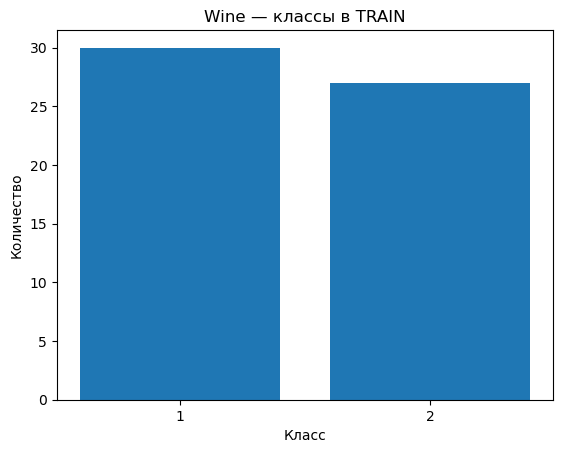

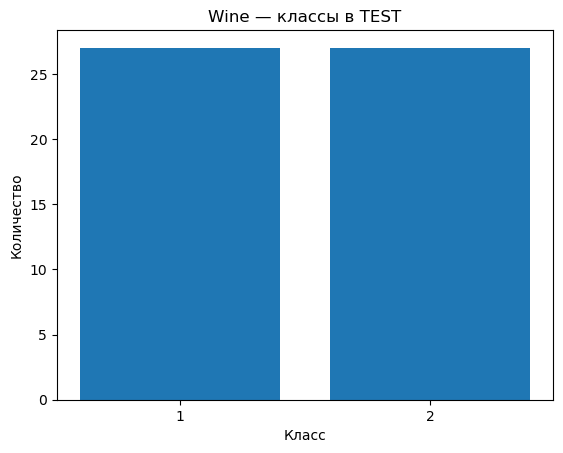

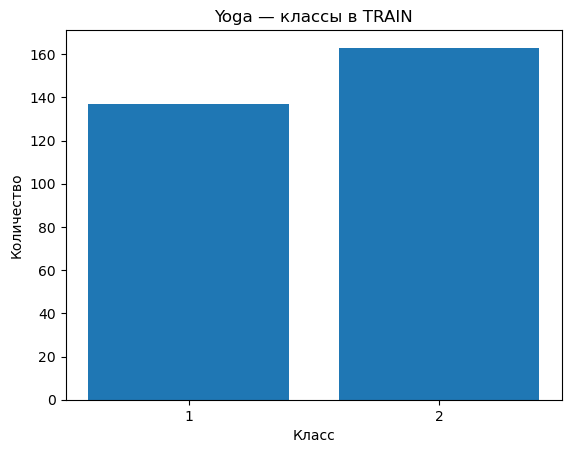

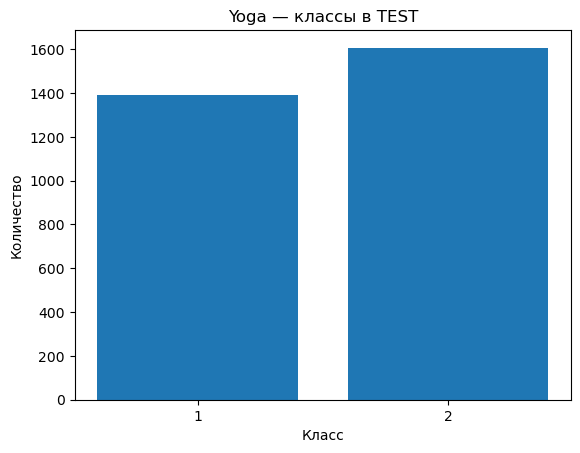

In [23]:
# Посмотрим, как распределяются объекты по классам в train/test
for ds_name, (Xtr, ytr, Xte, yte) in data_cache.items():
    # TRAIN
    uniq, counts = np.unique(ytr, return_counts=True)
    plt.figure()
    plt.bar(uniq.astype(str), counts)
    plt.title(f"{ds_name} — классы в TRAIN")
    plt.xlabel("Класс"); plt.ylabel("Количество")
    plt.show()

    # TEST
    uniq, counts = np.unique(yte, return_counts=True)
    plt.figure()
    plt.bar(uniq.astype(str), counts)
    plt.title(f"{ds_name} — классы в TEST")
    plt.xlabel("Класс"); plt.ylabel("Количество")
    plt.show()


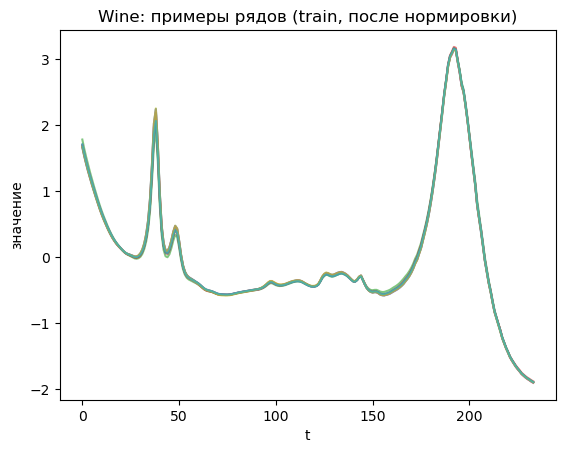

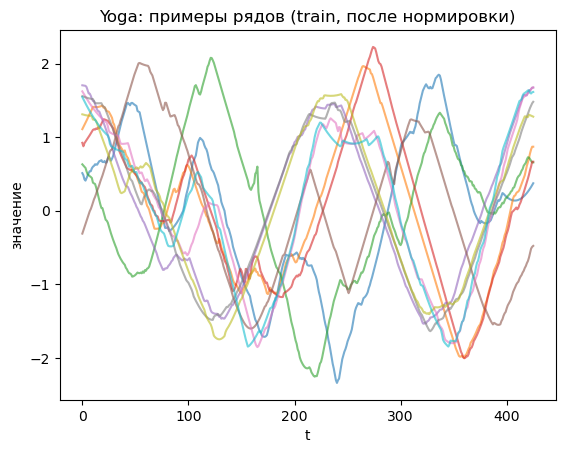

In [24]:
# Для наглядности нарисуем по несколько рядов каждого класса
rnd = np.random.RandomState(123)

for ds_name, (Xtr, ytr, _, _) in normed_sets.items():
    labels = np.unique(ytr)

    plt.figure()
    for c in labels:
        idxs = np.where(ytr == c)[0]
        # не более 5 рядов на класс
        if len(idxs) > 5:
            idxs = rnd.choice(idxs, size=5, replace=False)
        for i in idxs:
            plt.plot(Xtr[i], alpha=0.6)
    plt.title(f"{ds_name}: примеры рядов (train, после нормировки)")
    plt.xlabel("t")
    plt.ylabel("значение")
    plt.show()


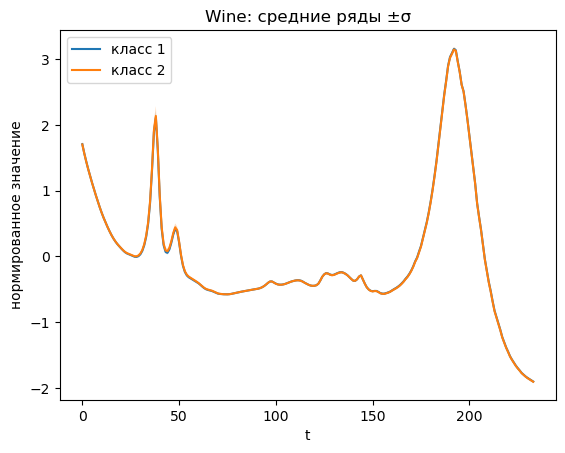

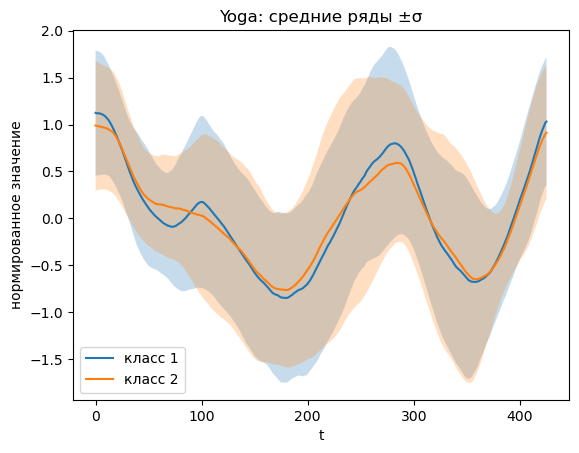

In [26]:
# Для каждого класса посмотрим усреднённый ряд + разброс (сигма)
for ds_name, (Xtr, ytr, _, _) in normed_sets.items():
    t_axis = np.arange(Xtr.shape[1])
    plt.figure()

    for c in np.unique(ytr):
        group = Xtr[ytr == c]
        avg = group.mean(axis=0)
        spread = group.std(axis=0)
        plt.plot(t_axis, avg, label=f"класс {c}", linewidth=1.5)
        plt.fill_between(t_axis, avg - spread, avg + spread, alpha=0.25)

    plt.title(f"{ds_name}: средние ряды ±σ")
    plt.xlabel("t"); plt.ylabel("нормированное значение")
    plt.legend()
    plt.show()


In [28]:
# Итоговые результаты и матрицы ошибок
results_table = []
conf_mats = {}

# На нормированных рядах запустим 1-NN (k=1, евклид)
for ds_name, (Xtr, ytr, Xte, yte) in normed_sets.items():
    t0 = time.time()

    clf = KNeighborsClassifier(n_neighbors=1, metric="euclidean", n_jobs=-1)
    clf.fit(Xtr, ytr)
    preds = clf.predict(Xte)

    t1 = time.time()

    acc = accuracy_score(yte, preds)
    bacc = balanced_accuracy_score(yte, preds)
    cm = confusion_matrix(yte, preds)

    print(f"{ds_name}: 1-NN на норм. рядах → acc={acc:.3f}, bal_acc={bacc:.3f}, время={t1-t0:.2f}c")
    display(pd.DataFrame(cm))

    results_table.append({
        "dataset": ds_name, "model": "1-NN (euclid)", 
        "accuracy": round(acc, 4),
        "balanced_accuracy": round(bacc, 4),
        "inference_sec": round(t1 - t0, 2)
    })
    conf_mats[(ds_name, "1-NN (euclid)")] = cm.tolist()


Wine: 1-NN на норм. рядах → acc=0.611, bal_acc=0.611, время=0.06c


,0,1
0,16,11
1,10,17


Yoga: 1-NN на норм. рядах → acc=0.830, bal_acc=0.828, время=0.07c


,0,1
0,1098,295
1,214,1393


In [27]:
# Для каждого ряда посчитаем компактные признаки
# (среднее, дисперсия, минимум, максимум, асимметрия, эксцесс, энергия и т.д.)
train_feats, test_feats = {}, {}

for ds_name, (Xtr, ytr, Xte, yte) in normed_sets.items():
    def extract_features(matrix):
        feats = []
        for seq in matrix:
            n = len(seq)
            mu, sd = seq.mean(), seq.std()
            z = (seq - mu) / (sd + 1e-12) if sd > 0 else np.zeros_like(seq)

            # базовые показатели
            row = {
                "mean": mu, "std": sd,
                "min": float(seq.min()), "max": float(seq.max()),
                "median": float(np.median(seq)),
                "skew": float(np.mean(z**3)),
                "kurt": float(np.mean(z**4) - 3.0),
                "energy": float(np.mean(seq**2)),
                "zero_cross": int(np.sum(np.signbit(seq)[:-1] != np.signbit(seq)[1:]))
            }

            # линейный тренд
            t = np.arange(n)
            row["slope"] = float(np.polyfit(t, seq, 1)[0]) if n > 1 else 0.0

            # автокорреляция на лагах 1–5
            x0 = seq - mu
            var = (x0**2).sum()
            if var == 0:
                acf = np.zeros(5)
            else:
                corr = np.correlate(x0, x0, mode="full")
                mid = len(corr)//2
                acf = corr[mid+1:mid+6] / var
            for j in range(5):
                row[f"acf_{j+1}"] = float(acf[j])

            feats.append(row)
        return pd.DataFrame(feats)

    train_feats[ds_name] = extract_features(Xtr)
    test_feats[ds_name] = extract_features(Xte)

    print(f"{ds_name}: фичей={train_feats[ds_name].shape[1]}, размеры TRAIN={train_feats[ds_name].shape}, TEST={test_feats[ds_name].shape}")
    display(train_feats[ds_name].head(3))


Wine: фичей=15, размеры TRAIN=(57, 15), TEST=(54, 15)


,mean,std,min,max,median,skew,kurt,energy,zero_cross,slope,acf_1,acf_2,acf_3,acf_4,acf_5
0,1.138690e-17,1.0,-1.923014,3.126290,-0.342242,1.160558,1.640021,1.0,5,-0.001652,0.977450,0.942689,0.900128,0.853551,0.805004
1,1.897817e-18,1.0,-1.923412,3.111953,-0.333693,1.150415,1.603278,1.0,5,-0.001643,0.977327,0.942255,0.899342,0.852514,0.803883
2,1.328472e-17,1.0,-1.926721,3.106443,-0.331099,1.143505,1.588682,1.0,5,-0.001671,0.977258,0.942019,0.898917,0.851926,0.803173


Yoga: фичей=15, размеры TRAIN=(300, 15), TEST=(3000, 15)


,mean,std,min,max,median,skew,kurt,energy,zero_cross,slope,acf_1,acf_2,acf_3,acf_4,acf_5
0,3.335881e-17,1.0,-2.147514,1.817730,-0.061847,-0.183745,-0.596899,1.0,6,0.001379,0.998973,0.996191,0.991801,0.985900,0.978570
1,6.671763e-17,1.0,-2.173054,1.930468,-0.110055,-0.100188,-0.592161,1.0,6,0.000423,0.996713,0.991513,0.984419,0.975734,0.965292
2,-1.667941e-17,1.0,-2.068631,1.535303,0.117642,-0.464057,-0.823073,1.0,10,0.000620,0.996613,0.991392,0.984429,0.975749,0.965462


In [29]:
# Теперь попробуем Random Forest на сконструированных признаках
for ds_name, (Xtr, ytr, Xte, yte) in normed_sets.items():
    Xtr_f, Xte_f = train_feats[ds_name], test_feats[ds_name]

    # базовая модель RF
    rf_base = RandomForestClassifier(random_state=0, n_jobs=-1)

    # сетка параметров для подбора (очень простая)
    grid = {"n_estimators": [200], "max_depth": [None, 15]}
    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

    search = GridSearchCV(rf_base, param_grid=grid, cv=cv, scoring="accuracy", n_jobs=-1)
    search.fit(Xtr_f, ytr)

    best_rf = search.best_estimator_
    preds = best_rf.predict(Xte_f)

    acc = accuracy_score(yte, preds)
    bacc = balanced_accuracy_score(yte, preds)
    cm = confusion_matrix(yte, preds)

    print(f"{ds_name}: RF по фичам → acc={acc:.3f}, bal_acc={bacc:.3f}, лучшие параметры={search.best_params_}")
    display(pd.DataFrame(cm))

    results_table.append({
        "dataset": ds_name, "model": "RF(features)",
        "accuracy": round(acc, 4),
        "balanced_accuracy": round(bacc, 4),
        "inference_sec": np.nan
    })
    conf_mats[(ds_name, "RF(features)")] = cm.tolist()


Wine: RF по фичам → acc=0.593, bal_acc=0.593, лучшие параметры={'max_depth': None, 'n_estimators': 200}


,0,1
0,19,8
1,14,13


Yoga: RF по фичам → acc=0.783, bal_acc=0.779, лучшие параметры={'max_depth': None, 'n_estimators': 200}


,0,1
0,1011,382
1,270,1337


In [30]:
# Финальная таблица со всеми экспериментами
summary = (
    pd.DataFrame(results_table)
    .sort_values(["dataset", "accuracy"], ascending=[True, False])
    .reset_index(drop=True)
)

print("🏁 Итоговая сводка:")
display(summary)


🏁 Итоговая сводка:


,dataset,model,accuracy,balanced_accuracy,inference_sec
0,Wine,1-NN (euclid),0.6111,0.6111,0.06
1,Wine,RF(features),0.5926,0.5926,NaN
2,Yoga,1-NN (euclid),0.8303,0.8275,0.07
3,Yoga,RF(features),0.7827,0.7789,NaN
